In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib import cm
import os

In [7]:
df_prev = pd.read_spss('data/CASPIANI.sav',convert_categoricals=True)  
df = pd.read_spss('data/caspian1 data.sav',convert_categoricals=True)  

df_iii = pd.read_spss('data/CASPIAN III.sav',convert_categoricals=True) 
df_iv = pd.read_spss('data/caspian4_.sav',convert_categoricals=True)
df_iv_modified = pd.read_spss('data/caspian4_modified.sav',convert_categoricals=True)

df_v = pd.read_spss('data/last-caspian-v.sav',convert_categoricals=True) 
def rename_features(df1, caspian_number):
    df2 = df1.copy()
    # Rename the features in the dataframe
    if caspian_number == 5:
        df2.rename(columns={'weight_1': 'weight', 'height_2': 'height', 'universi': 'university','ap_9':'schoolType'}, inplace=True)
    elif caspian_number == 4:
        df2.drop('sex', axis=1, inplace=True)
        df2.rename(columns={'sex2': 'sex', 'weight_1': 'weight', 'height_2': 'height', 'University': 'university','ap_9':'schoolType'}, inplace=True)
    elif caspian_number == 3:
        df2.rename(columns={'weighte': 'weight', 'heighte': 'height', 'province': 'university', 'area':'region','p9':'schoolType'}, inplace=True)
    elif caspian_number == 1:
        df2.columns = df.columns.str.lower()
        df2.rename(columns={'univer': 'university','district':'region', 'schoolty':'schoolType'}, inplace=True)
    if caspian_number == 11:
        df2.columns = df2.columns.str.lower()
        df2.rename(columns={'univer': 'university','district':'region', 'schoolty':'schoolType', 'wc':'waist'}, inplace=True)         
    return df2
        

    return df2
df_prev = rename_features(df_prev,11)
df = rename_features(df,1)
df_iv=rename_features(df_iv,4)
df_iii = rename_features(df_iii,3)
df_v = rename_features(df_v,5)
df_prev['sex'] = df_prev['sex'].apply(lambda x: 'Girl' if x == 'Female' else 'Boy' if x == 'Male' else x)
df['sex'] = df['sex'].apply(lambda x: 'Girl' if x == 'Female' else 'Boy' if x == 'Male' else x)
df['region'] = df['region'].apply(lambda x: 'urban' if x == 'Urban' else 'rural' if x == 'Rural' else x)
df_iii['sex'] = df_iii['sex'].apply(lambda x: 'Boy' if x == 'female' else 'Girl' if x == 'male' else x)
df_iv['sex'] = df_iv['sex'].apply(lambda x: 'Girl' if x == 'girl' else 'Boy' if x == 'boy' else x)
df_iv_modified['sex'] = df_iv_modified['sex'].apply(lambda x: 'Girl' if x == 'girl' else 'Boy' if x == 'boy' else x)

df_iii['schoolType']=df_iii['schoolType'].apply(lambda x: 'Public School' if x=='dolati' else 'Private School' if x=='gheyre entefaei' else 'Unknown') 
df_iv['schoolType']=df_iv['schoolType'].apply(lambda x: 'Public School' if x=='dolati' else 'Private School' if x=='gheyre entef' else 'Unknown') 
df_v['schoolType']=df_v['schoolType'].apply(lambda x: 'Public School' if x=='dolati' else 'Private School' if x=='gheyre entefai' else 'Unknown') 
df_dict = {'caspian_I_prev':df_prev,'caspian_I': df, 'caspian_III': df_iii,'caspian_IV_modified':df_iv_modified,'caspian_V': df_v}
def preprocess(dataframes_dict):
    processed_dfs = {}  # Dictionary to store processed DataFrames
    for name, df_org in dataframes_dict.items():
        df = df_org.copy()

        # Filter age
        df = df[(df["age"] >= 7) & (df["age"] <= 18)]
        # please change the type of heught_1 and weight_1 in caspian4 to numeric if you can't do it directly uncomment two line below
        df['height'] = pd.to_numeric(df['height'], errors='coerce')
        df['weight'] = pd.to_numeric(df['weight'], errors='coerce')
        df["bmi1"] = df["weight"] / ((df["height"] / 100) ** 2)
        
        # Remove null tuples
        records_with_nulls = df[
            df[["weight", "height", "sex", "age"]].isna().any(axis=1)
        ]
        df = df.dropna(subset=["height", "weight", "sex"])
        print(
            f"Number of records with NaN value in weight or height in {name}: {len(records_with_nulls)}"
        )

        # Store the processed DataFrame in the new dictionary
        processed_dfs[name] = df

    return processed_dfs


# Usage
processed_dfs = preprocess(df_dict)

Number of records with NaN value in weight or height in caspian_I_prev: 11
Number of records with NaN value in weight or height in caspian_I: 132
Number of records with NaN value in weight or height in caspian_III: 0
Number of records with NaN value in weight or height in caspian_IV_modified: 0
Number of records with NaN value in weight or height in caspian_V: 128


Height Distribution by Age for Sex

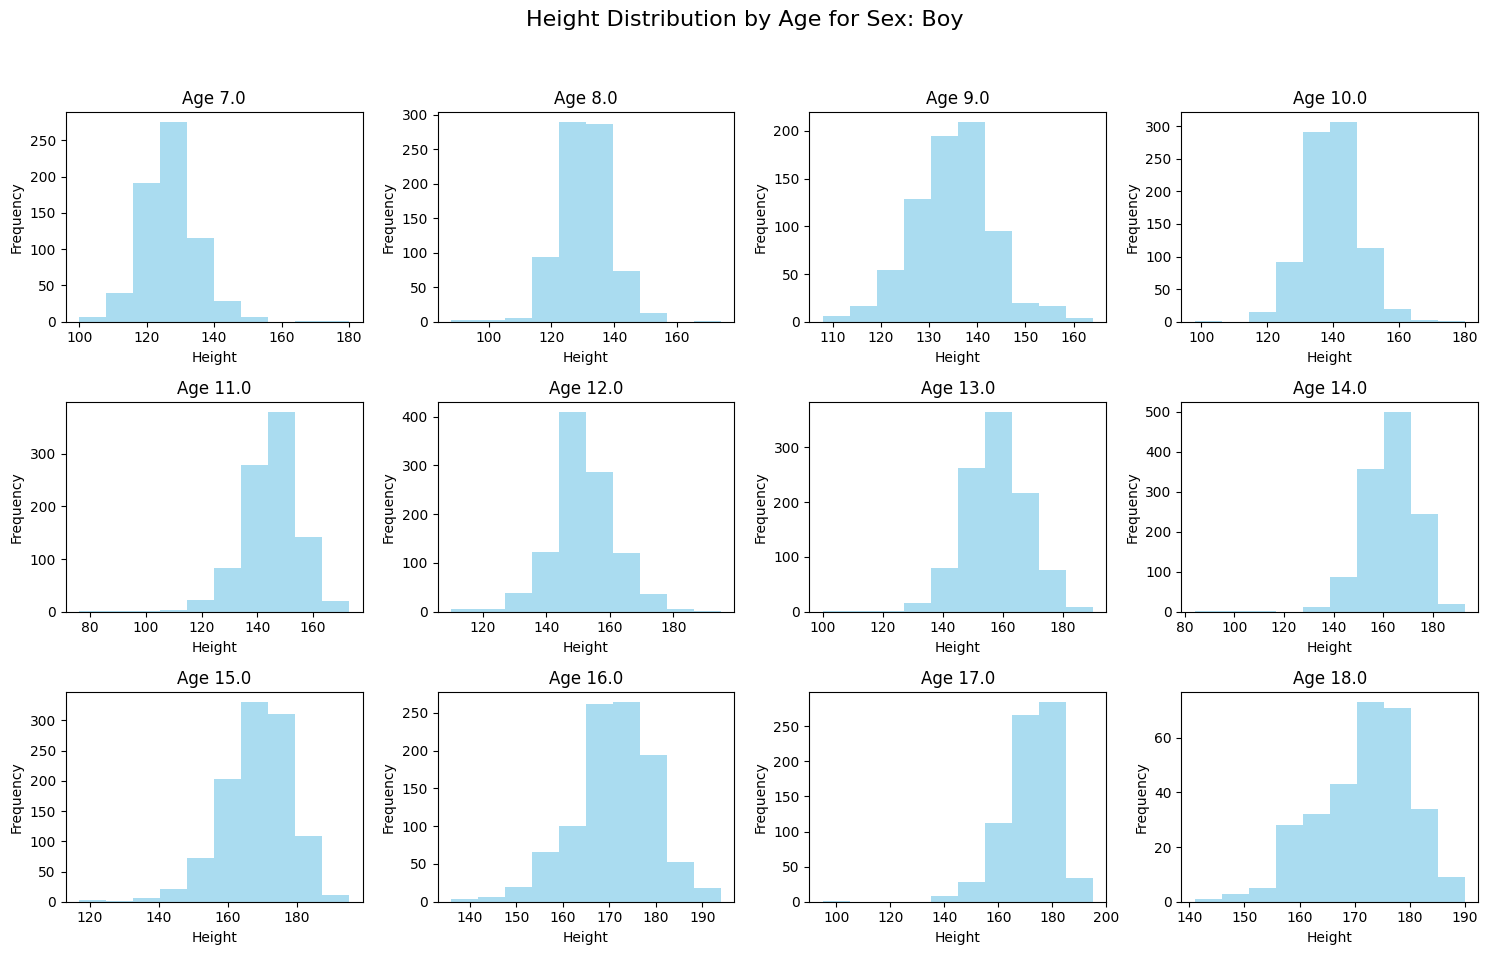

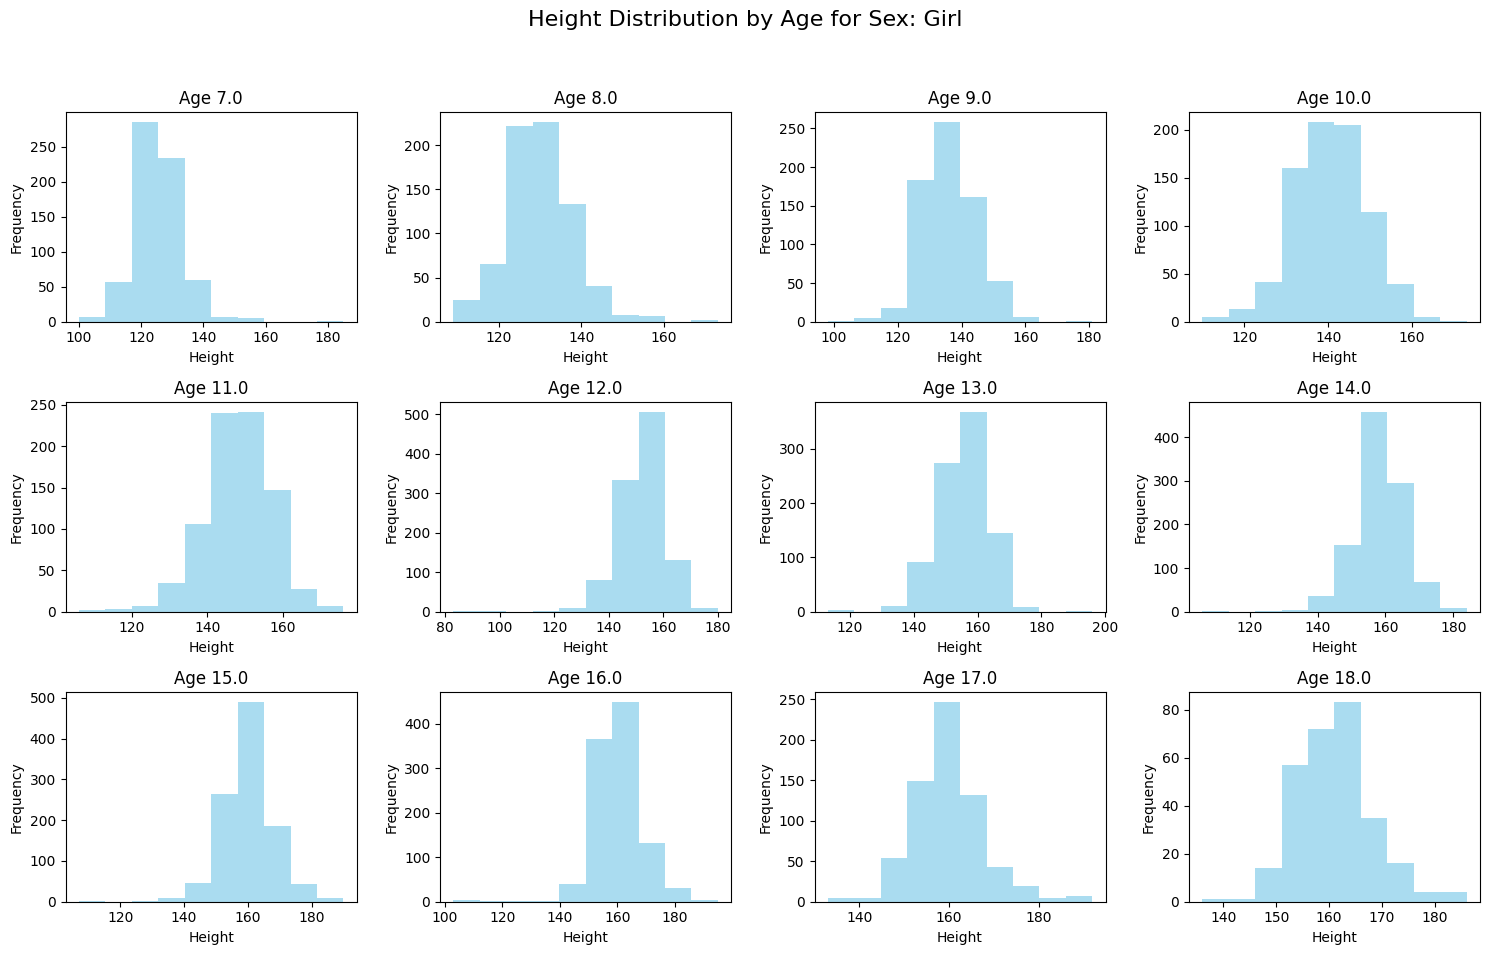

In [8]:
import matplotlib.pyplot as plt

# Retrieve unique ages and sexes
ages = sorted(processed_dfs['caspian_I']['age'].unique())  # Sort ages
sexes = processed_dfs['caspian_I']['sex'].unique()

# Set up the grid size
rows, cols = 3, 4  # Adjust based on the number of ages or desired layout
figsize = (15, 10)  # Adjust figure size as needed

# Loop through each sex and create a separate figure for each
for sex in sexes:
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    fig.suptitle(f'Height Distribution by Age for Sex: {sex}', fontsize=16)
    
    # Loop through each age and place each histogram in the grid
    for i, age in enumerate(ages):
        row, col = divmod(i, cols)  # Determine row and column for the subplot
        ax = axes[row, col]  # Select the specific subplot axis
        
        # Filter data by age and sex
        subset = processed_dfs['caspian_I'][(processed_dfs['caspian_I']['age'] == age) & 
                                             (processed_dfs['caspian_I']['sex'] == sex)]
        
        # Plot histogram if there is data for this age-sex group
        if not subset.empty:
            ax.hist(subset['height'], bins=10, alpha=0.7, color='skyblue')
            ax.set_title(f'Age {age}')
            ax.set_xlabel('Height')
            ax.set_ylabel('Frequency')
        else:
            ax.axis('off')  # Hide the subplot if no data is available for the age-sex group
    
    # Hide any extra subplots if ages < rows * cols
    for j in range(i + 1, rows * cols):
        row, col = divmod(j, cols)
        axes[row, col].axis('off')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit title
    plt.show()


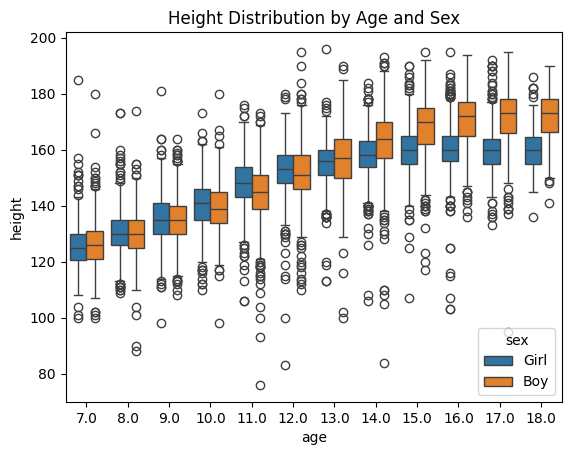

In [9]:
import seaborn as sns

sns.boxplot(data=processed_dfs['caspian_I'], x='age', y='height', hue='sex')
plt.title('Height Distribution by Age and Sex')
plt.show()


statistical test for finding is the distribution Normal or not?
<ul>
<li>shapiro-Wilk</li>
<li>Anderson-Darling</li>
</ul>

In [10]:
from scipy import stats
# Specify the age group
age = 16
# Loop through each sex
sexes = processed_dfs['caspian_I']['sex'].unique()
for sex in sexes:
    # Filter data for the specific age and sex
    data_subset = processed_dfs['caspian_I'][(processed_dfs['caspian_I']['age'] == age) & 
                                             (processed_dfs['caspian_I']['sex'] == sex)]['height']
    
    # Perform the Shapiro-Wilk test
    shapiro_stat, shapiro_p = stats.shapiro(data_subset)
    print(f'Shapiro-Wilk Test for Age {age}, Sex {sex}: Statistic={shapiro_stat}, p-value={shapiro_p}')
    
    # Perform the Anderson-Darling test
    # critical levels for dist norm is (15%, 10%, 5%, 2.5%, 1%)
    anderson_result = stats.anderson(data_subset, dist='norm')
    # print(anderson_result.significance_level)
    print(f'Anderson-Darling Test for Age {age}, Sex {sex}: Statistic={anderson_result.statistic}, '
          f'Critical Values={anderson_result.critical_values}')
    


Shapiro-Wilk Test for Age 16, Sex Boy: Statistic=0.9870445334479179, p-value=1.204590735129535e-07
Anderson-Darling Test for Age 16, Sex Boy: Statistic=3.0858540784496427, Critical Values=[0.574 0.653 0.784 0.914 1.088]
Shapiro-Wilk Test for Age 16, Sex Girl: Statistic=0.9275140371032214, p-value=7.033826184157256e-22
Anderson-Darling Test for Age 16, Sex Girl: Statistic=8.464491031239504, Critical Values=[0.574 0.653 0.784 0.914 1.088]


Outlier detection with modified z-score
<li>bar chart of number of outliers</li>

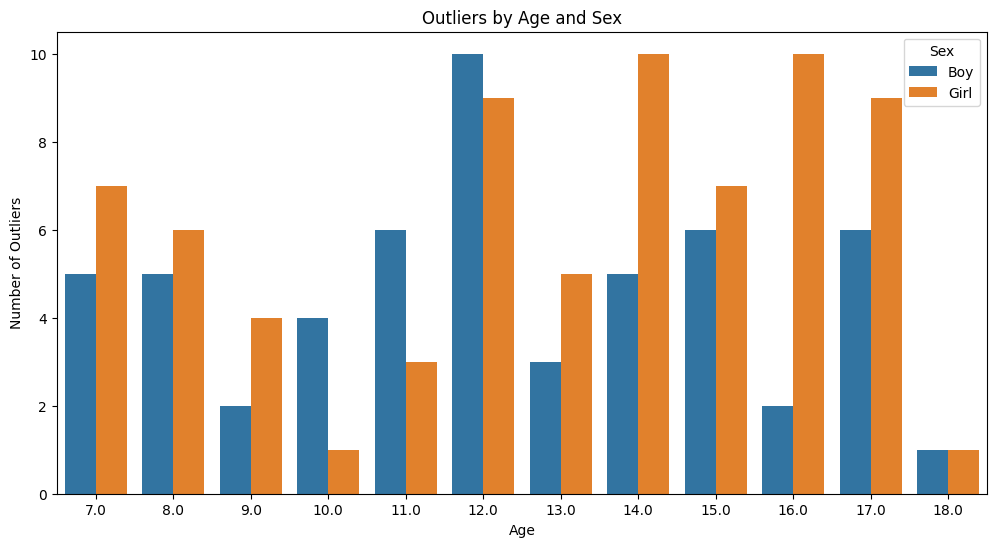

In [11]:
import numpy as np
import pandas as pd

# Initialize an empty list to store rows for the table
results = []

ages = sorted(processed_dfs['caspian_I']['age'].unique())  # Sort ages
sexes = processed_dfs['caspian_I']['sex'].unique()

# Loop over each sex and age group to calculate data points and outliers
for sex in sexes:
    for age in ages:
        height_data = processed_dfs['caspian_I'][(processed_dfs['caspian_I']['age'] == age) & (processed_dfs['caspian_I']['sex'] == sex)]['height']

        # Calculate the Median and MAD
        median = np.median(height_data)
        mad = np.median(np.abs(height_data - median))

        # Compute the Modified Z-score
        modified_z_scores = 0.6745 * (height_data - median) / mad

        # Identify Outliers
        threshold = 3.5
        outliers = height_data[np.abs(modified_z_scores) > threshold]

        # Append the results for this age and sex group to the list
        results.append({
            'Age': age,
            'Sex': sex,
            'Total Data Points': len(height_data),
            'Outliers': len(outliers)
        })

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

# Print or display the table
# print(results_df)

# You can plot this data as a bar chart, for example, using the following:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x='Age', y='Outliers', hue='Sex', data=results_df)
plt.title('Outliers by Age and Sex')
plt.xlabel('Age')
plt.ylabel('Number of Outliers')
plt.legend(title='Sex')
plt.show()


<li>Table of total number of data in each group and number of outliers with modified z-score</li>

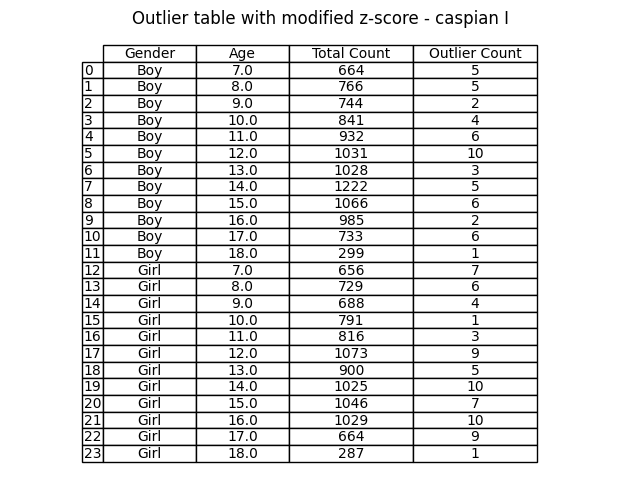

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import table

# Initialize an empty list to collect data for each age and sex
table_data = []

# Get unique ages and sexes
ages = sorted(processed_dfs['caspian_I']['age'].unique())
sexes = processed_dfs['caspian_I']['sex'].unique()

# Loop through each sex and age to calculate the data
for sex in sexes:
    for age in ages:
        height_data = processed_dfs['caspian_I'][(processed_dfs['caspian_I']['age'] == age) & 
                                                 (processed_dfs['caspian_I']['sex'] == sex)]['height']
        
        # Calculate the Median and MAD
        median = np.median(height_data)
        mad = np.median(np.abs(height_data - median))

        # Compute the Modified Z-score for each point
        modified_z_scores = 0.6745 * (height_data - median) / mad

        # Identify Outliers
        threshold = 3.5
        outliers = height_data[np.abs(modified_z_scores) > threshold]

        # Collect data for this group
        table_data.append([sex, age, len(height_data), len(outliers)])

# Create a DataFrame from the collected data
table_df = pd.DataFrame(table_data, columns=['Gender', 'Age', 'Total Count', 'Outlier Count'])

# Plot the table as an image
fig, ax = plt.subplots(figsize=(8, len(table_df) * 0.24))  # Adjust height based on data size
ax.set_title('Outlier table with modified z-score - caspian I')
ax.axis('tight')
ax.axis('off')
tbl = table(ax, table_df, loc='center', cellLoc='center', colWidths=[0.15, 0.15, 0.2, 0.2])

# Save the table as an image
plt.savefig("outlier_table_z-score.png", bbox_inches='tight', dpi=300)
plt.show()


<li>Table of total number of data in each group and number of outliers with IQR</li>

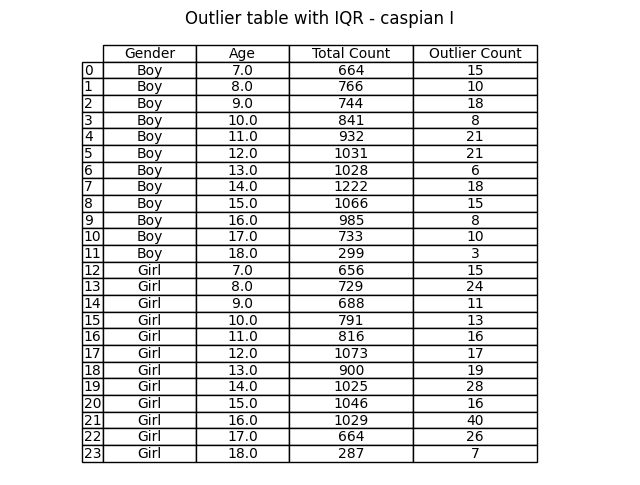

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import table

# Initialize an empty list to collect data for each age and sex
table_data = []

# Get unique ages and sexes
ages = sorted(processed_dfs['caspian_I']['age'].unique())
sexes = processed_dfs['caspian_I']['sex'].unique()

# Loop through each sex and age to calculate the data
for sex in sexes:
    for age in ages:
        height_data = processed_dfs['caspian_I'][(processed_dfs['caspian_I']['age'] == age) & 
                                                 (processed_dfs['caspian_I']['sex'] == sex)]['height']
        
        # Calculate Q1 and Q3
        Q1 = np.percentile(height_data, 25)
        Q3 = np.percentile(height_data, 75)
        
        # Compute the IQR
        IQR = Q3 - Q1
        
        # Calculate the lower and upper bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Identify Outliers
        outliers = height_data[(height_data < lower_bound) | (height_data > upper_bound)]

        # Collect data for this group
        table_data.append([sex, age, len(height_data), len(outliers)])

# Create a DataFrame from the collected data
table_df = pd.DataFrame(table_data, columns=['Gender', 'Age', 'Total Count', 'Outlier Count'])

# Plot the table as an image
fig, ax = plt.subplots(figsize=(8, len(table_df) * 0.24))  # Adjust height based on data size
ax.axis('off')
ax.set_title('Outlier table with IQR - caspian I')
ax.axis('tight')
tbl = table(ax, table_df, loc='center', cellLoc='center', colWidths=[0.15, 0.15, 0.2, 0.2])

# Save the table as an image
plt.savefig("outlier_table_IQR.png", bbox_inches='tight', dpi=300)
plt.show()


plot all percentile for all datasets for wieght and height

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

# Initialize an empty list to collect data for percentiles
percentile_data = []
frac = 0.7
percentile = [3, 10, 25, 50, 75, 90, 97]
percentiles_labels = ['P3', 'P10', 'P25', 'P50', 'P75','P90', 'P97']
features = ['height']

# Loop through each dataset in processed_dfs
for df_name, df in processed_dfs.items():
    ages = sorted(df['age'].unique())
    sexes = df['sex'].unique()

    # Loop through each feature to calculate the percentiles
    for feature in features:
        for sex in sexes:
            for age in ages:
                height_data = df[(df['age'] == age) & (df['sex'] == sex)][f'{feature}']
                # Convert to numeric, coercing errors to NaN
                height_data = pd.to_numeric(height_data, errors='coerce')
                height_data = height_data.dropna()  # Remove NaN values

                # Check if there's enough data
                if height_data.size == 0:
                    print(f"No valid data for sex: {sex}, age: {age}. Skipping...")
                    continue  # Skip to the next iteration

                # Calculate the Median and MAD
                median = np.median(height_data)
                mad = np.median(np.abs(height_data - median))

                # Compute the Modified Z-score for each point
                modified_z_scores = 0.6745 * (height_data - median) / mad

                # Filter out outliers
                height_no_outliers = height_data[np.abs(modified_z_scores) <= 3.5]
                # print(height_no_outliers)

                # Calculate the desired percentiles
                percentiles_values = np.percentile(height_no_outliers, percentile)
                # print(percentiles_values)
                
                # Collect data for this group
                percentile_data.append([sex, age] + percentiles_values.tolist())
                # print(percentile_data)
        # Create a DataFrame from the collected percentile data
        percentile_columns = ['Gender', 'Age'] + percentiles_labels
        percentile_df = pd.DataFrame(percentile_data, columns=percentile_columns)

        # Create separate plots for boys and girls
        for sex in sexes:
            fig, ax = plt.subplots(figsize=(12, 6))

            sex_data = percentile_df[percentile_df['Gender'] == sex]
            print(sex_data)
            for percentile_label in percentiles_labels:
                smoothed_percentile = lowess(sex_data[percentile_label], sex_data['Age'], frac=frac)
                ax.plot(smoothed_percentile[:, 0], smoothed_percentile[:, 1], linestyle='', label=f'Smoothed {percentile_label}')
            print(smoothed_percentile)
            # Title and labels
            name = f'{feature} Percentiles by Age - {sex.capitalize()} (Outliers Removed) - {df_name}'
            ax.set_title(f'{name}')
            ax.set_xlabel('Age')
            ax.set_ylabel(f'{feature}')
            ax.legend()
            plt.grid()
            plt.xticks(sex_data['Age'])
            plt.savefig(f'chart-caspian2/{name}.png')  # Save the plot with .png extension
            plt.close()
            # Show the plot
            # plt.show()

        # Clear the percentile_data for the next feature
        percentile_data.clear()


   Gender   Age      P3    P10     P25    P50     P75    P90     P97
0    Girl   7.0  115.34  117.0  121.00  124.0  128.00  131.0  135.66
1    Girl   8.0  116.00  120.8  125.00  129.0  133.50  136.0  140.00
2    Girl   9.0  123.00  125.0  130.75  134.0  140.00  145.0  150.63
3    Girl  10.0  129.39  132.0  137.00  142.0  146.75  153.0  158.61
4    Girl  11.0  132.10  140.0  144.00  149.0  155.00  159.0  162.00
5    Girl  12.0  138.26  145.0  149.00  154.0  159.00  162.0  167.00
6    Girl  13.0  144.00  147.0  152.00  157.0  161.00  164.0  168.41
7    Girl  14.0  146.00  151.0  155.00  158.0  163.00  168.0  173.00
8    Girl  15.0  147.63  151.1  155.00  159.0  165.00  172.0  177.00
9    Girl  16.0  148.00  152.3  155.00  160.0  165.00  169.0  175.91
10   Girl  17.0  147.00  152.0  155.00  159.0  163.00  169.0  173.53
11   Girl  18.0  149.90  151.5  155.00  160.0  164.00  171.0  179.15
[[  7.         135.64493283]
 [  8.         142.40271283]
 [  9.         148.98581623]
 [ 10.         1

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Initialize an empty list to collect data for percentiles and counts
percentile_data = []
count_data = []
percentile = [3, 5, 10, 25, 50, 75,  90, 95, 97]
percentiles_labels = ['P3', 'P5', 'P10', 'P25', 'P50', 'P75', 'P90', 'P95', 'P97']
features = ['weight','height']

# Loop through each dataset in processed_dfs
for df_name, df in processed_dfs.items():
    ages = sorted(df['age'].unique())
    sexes = df['sex'].unique()

    # Loop through each feature to calculate the percentiles
    for feature in features:
        for sex in sexes:
            for age in ages:
                height_data = df[(df['age'] == age) & (df['sex'] == sex)][f'{feature}']
                height_data = pd.to_numeric(height_data, errors='coerce')
                height_data = height_data.dropna()  # Remove NaN values

                # Check if there's enough data
                if height_data.size == 0:
                    print(f"No valid data for sex: {sex}, age: {age}. Skipping...")
                    continue

                # Calculate the Median and MAD
                median = np.median(height_data)
                mad = np.median(np.abs(height_data - median))

                # Compute the Modified Z-score for each point
                modified_z_scores = 0.6745 * (height_data - median) / mad

                # Filter out outliers
                height_no_outliers = height_data[np.abs(modified_z_scores) <= 3.5]

                # Calculate the desired percentiles and the count of data points in each percentile range
                percentiles_values = np.percentile(height_no_outliers, percentile)
                percentile_counts = [
                    ((height_no_outliers <= percentiles_values[i]).sum() - 
                     (height_no_outliers <= (percentiles_values[i-1] if i > 0 else -np.inf)).sum())
                    for i in range(len(percentile))
                ]

                # Collect data for this group
                count_data.append([sex, age] + percentile_counts)

        # Create a DataFrame from the collected count data
        count_columns = ['Gender', 'Age'] + [f'{p}_Count' for p in percentiles_labels]
        count_df = pd.DataFrame(count_data, columns=count_columns)

        # Create the table without the plot
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.axis('tight')
        ax.axis('off')

        # Set the title
        title = f'{feature} Percentiles by Age - {sex.capitalize()} (Outliers Removed) - {df_name}'
        ax.set_title(title, fontsize=12, fontweight='bold')

        # Convert the DataFrame to a table and add it to the figure
        table_data = count_df[['Gender', 'Age'] + [f'{p}_Count' for p in percentiles_labels]].values
        col_labels = ['Gender', 'Age'] + [f'{p}_Count' for p in percentiles_labels]
        table = ax.table(cellText=table_data, colLabels=col_labels, cellLoc='center', loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(8)

        # Save the table as an image
        plt.savefig(f'table-caspian2/{feature}_percentile_counts_{df_name}.png', bbox_inches='tight')
        plt.close()

        # Clear the count_data for the next feature
        count_data.clear()


plot 50 percentile of all datasets for boys and girls

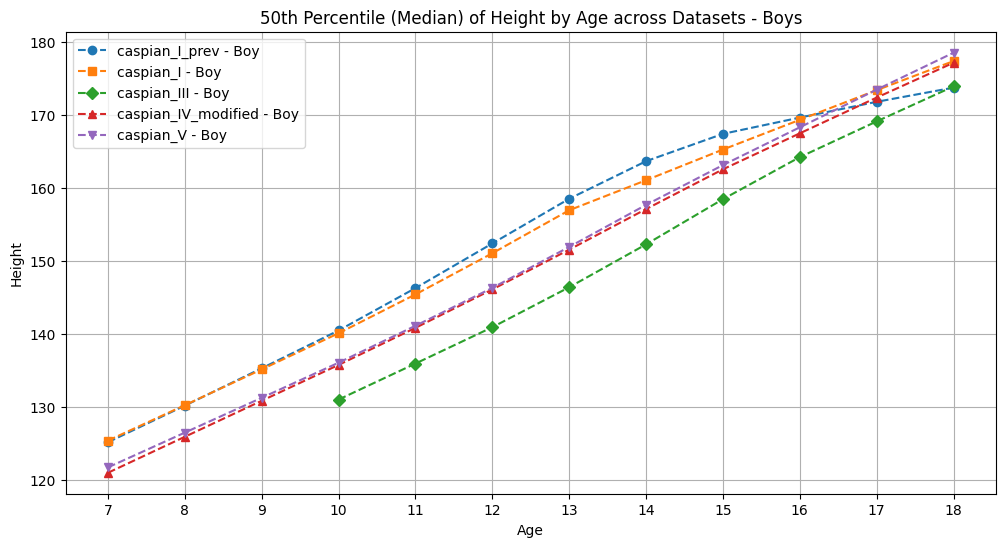

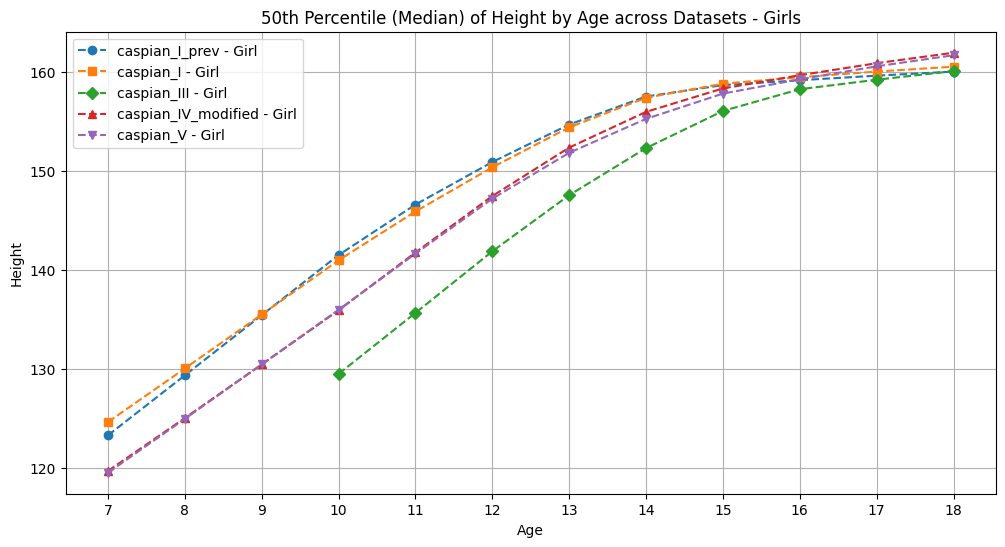

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
import itertools

# List of markers to cycle through
markers = ['o', 's', 'D', '^', 'v', 'p', '*', 'H', '+', 'x']  # Add more markers if needed

# Initialize a dictionary to store median (50th percentile) data for each dataset
median_data = {}
frac = 0.7
feature = 'height'  # Change this to 'weight' or 'bmi1' if needed
percentile = 50  # 50th percentile

# Loop through each dataset in processed_dfs
for df_name, df in processed_dfs.items():

    median_values = []
    ages = sorted(df['age'].unique())
    sexes = df['sex'].unique()
    
    for sex in sexes:
        sex_median_values = []
        if sex == '':  # Skip if sex is an empty string
            continue
        
        for age in ages:
            feature_data = df[(df['age'] == age) & (df['sex'] == sex)][feature]
            

            # Convert to numeric, coercing errors to NaN
            feature_data = pd.to_numeric(feature_data, errors='coerce').dropna()  # Remove NaN values

            # Check if there's enough data
            if feature_data.size == 0:
                print(f"No valid data for sex: {sex}, age: {age} in {df_name}. Skipping...")
                sex_median_values.append(np.nan)
                print(df_name)
                continue

            # Calculate the median and MAD for outlier removal
            median = np.median(feature_data)
            mad = np.median(np.abs(feature_data - median))
            modified_z_scores = 0.6745 * (feature_data - median) / mad
            feature_no_outliers = feature_data[np.abs(modified_z_scores) <= 3.5]

            # Calculate the 50th percentile (median) for cleaned data
            median_value = np.percentile(feature_no_outliers, percentile)
            sex_median_values.append(median_value)
        
        median_values.append((ages, sex_median_values, sex))

    median_data[df_name] = median_values

# Plot the 50th percentile (median) data for boys and girls on separate charts
for sex in ['Boy', 'Girl']:
    fig, ax = plt.subplots(figsize=(12, 6))
    marker_cycle = itertools.cycle(markers)  # Cycle through the marker list

    for df_name, median_values in median_data.items():
        for ages, sex_median_values, gender in median_values:
            if gender == sex:
                # Smooth the data
                smoothed_data = lowess(sex_median_values, ages, frac=frac, missing='drop')
                marker = next(marker_cycle)  # Get a unique marker for each dataset
                
                # Plot smoothed median for each dataset with unique marker
                ax.plot(smoothed_data[:, 0], smoothed_data[:, 1], linestyle='--', marker=marker, label=f'{df_name} - {gender}')

    # Title and labels
    ax.set_title(f'50th Percentile (Median) of {feature.capitalize()} by Age across Datasets - {sex}s')
    ax.set_xlabel('Age')
    ax.set_ylabel(f'{feature.capitalize()}')
    ax.legend()
    plt.grid()
    plt.xticks(ages)
    plt.savefig(f'chart-caspians/combined_50th_percentile_{sex}.png')  # Save the plot for each gender
    plt.show()


In [17]:
processed_dfs['caspian_I_prev'].sex.unique()

['Girl', 'Boy']
Categories (2, object): ['Girl', 'Boy']

caspian_I_prev
caspian_I
caspian_III
caspian_IV_modified
caspian_V


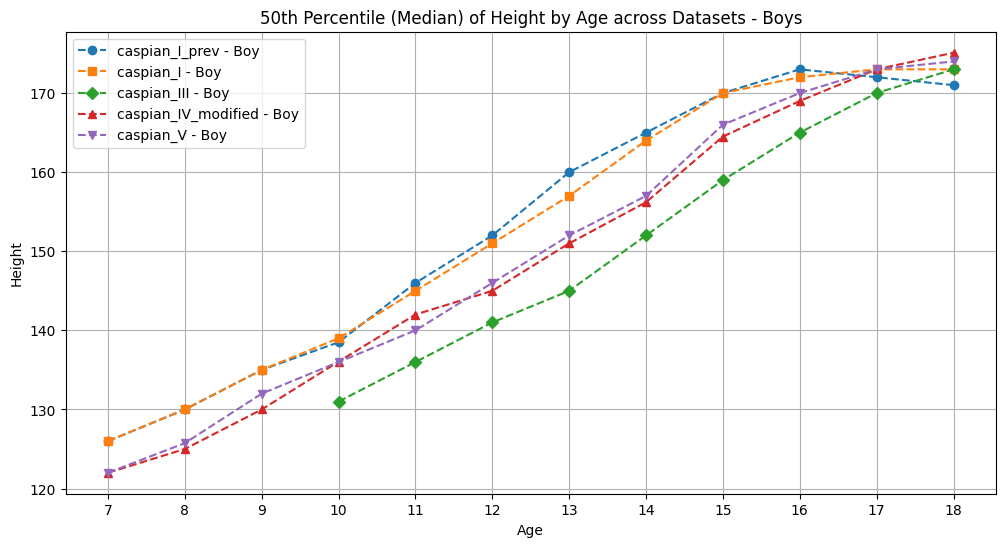

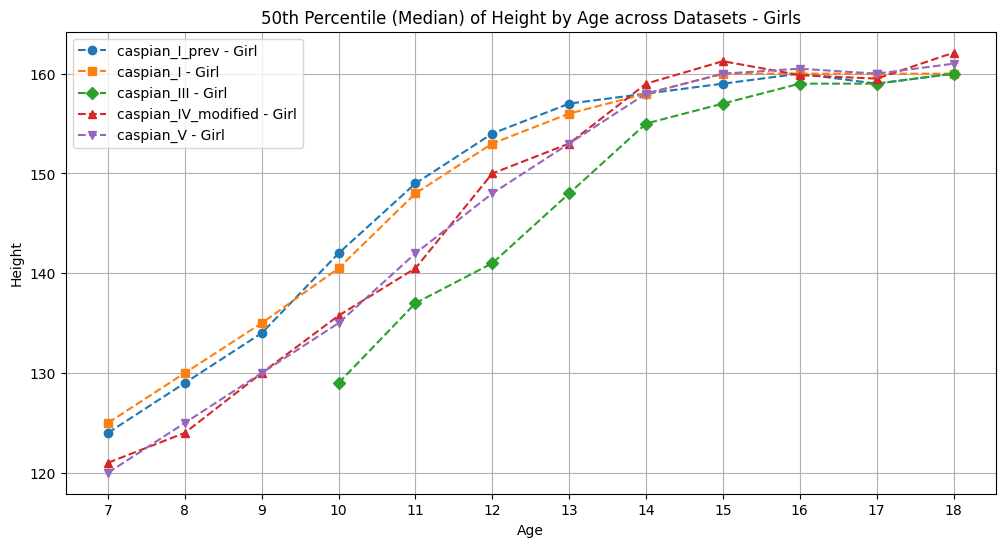

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

# List of markers to cycle through
markers = ['o', 's', 'D', '^', 'v', 'p', '*', 'H', '+', 'x']  # Add more markers if needed

# Initialize a dictionary to store median (50th percentile) data for each dataset
median_data = {}
feature = 'height'  # Change this to 'weight' or 'bmi1' if needed
percentile = 50  # 50th percentile

# Loop through each dataset in processed_dfs
for df_name, df in processed_dfs.items():
    print(df_name)
    median_values = []
    ages = sorted(df['age'].unique())
    sexes = df['sex'].unique()
    
    for sex in sexes:
        sex_median_values = []
        if sex == '':  # Skip if sex is an empty string
            continue
        
        for age in ages:
            feature_data = df[(df['age'] == age) & (df['sex'] == sex)][feature]
            
            # Convert to numeric, coercing errors to NaN
            feature_data = pd.to_numeric(feature_data, errors='coerce').dropna()  # Remove NaN values

            # Check if there's enough data
            if feature_data.size == 0:
                print(f"No valid data for sex: {sex}, age: {age} in {df_name}. Skipping...")
                sex_median_values.append(np.nan)
                print(df_name)
                continue

            # Calculate the median and MAD for outlier removal
            median = np.median(feature_data)
            mad = np.median(np.abs(feature_data - median))
            modified_z_scores = 0.6745 * (feature_data - median) / mad
            feature_no_outliers = feature_data[np.abs(modified_z_scores) <= 3.5]

            # Calculate the 50th percentile (median) for cleaned data
            median_value = np.percentile(feature_no_outliers, percentile)
            sex_median_values.append(median_value)
        
        median_values.append((ages, sex_median_values, sex))

    median_data[df_name] = median_values

# Plot the 50th percentile (median) data for boys and girls on separate charts
for sex in ['Boy', 'Girl']:
    fig, ax = plt.subplots(figsize=(12, 6))
    marker_cycle = itertools.cycle(markers)  # Cycle through the marker list

    for df_name, median_values in median_data.items():
        for ages, sex_median_values, gender in median_values:
            if gender == sex:
                marker = next(marker_cycle)  # Get a unique marker for each dataset
                
                # Plot raw median data without smoothing
                ax.plot(ages, sex_median_values, linestyle='--', marker=marker, label=f'{df_name} - {gender}')

    # Title and labels
    ax.set_title(f'50th Percentile (Median) of {feature.capitalize()} by Age across Datasets - {sex}s')
    ax.set_xlabel('Age')
    ax.set_ylabel(f'{feature.capitalize()}')
    ax.legend()
    plt.grid()
    plt.xticks(ages)
    plt.savefig(f'chart-caspians/combined_50th_percentile_{sex}_not-smooth.png')  # Save the plot for each gender
    plt.show()
